In [ ]:
!nvidia-smi

/bin/bash: nvidia-smi: command not found


In [1]:
from scipy.io import loadmat
import torch
import numpy as np
import pandas as pd
#import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
global dev
dev=torch.device('cuda:0')

In [3]:
# Load data
#data = loadmat('/content/drive/MyDrive/Projects/Data/DeepDenoise/spectraw.mat')
data = loadmat('../../../data/Denoising/test_spect_noiseshot08.mat')
test_data = torch.tensor(data['spectest_full'], dtype=float, device=dev)

## Auxiliary functions

Then we reshape the data to a format compatible with the model imput

In [4]:
# Reshape the data to a format compatible with the model input

def reformat_data(data,window,SampRate=5):
  """Function used to reformat the data according to the denoising model input"""
  window_sample = np.round(window*0.8)
  times = torch.arange(window*SampRate,len(data)-window*SampRate,window_sample*SampRate*2,dtype=int)
  datar = torch.zeros((times.shape[0]-1,1,2*window*SampRate+1,data.shape[1]),device=dev)
  datar_original = torch.zeros((times.shape[0]-1,1,2*window*SampRate+1,data.shape[1]),device=dev)
  #mean_data = torch.zeros((times.shape[0],data.shape[1]))
  last_sample = torch.zeros((1,1,len(data)-(times[-1]-int(window*SampRate)),data.shape[1]),device=dev)
  last_sample_original = torch.zeros((1,1,len(data)-(times[-1]-int(window*SampRate)),data.shape[1]),device=dev)

  for i,t in enumerate(times[:-1]):
    data_seg = data[t-window*SampRate:t+window*SampRate+1,:]
    datar[i,0,:,:] = data_seg
    
    
  sample = data[times[-1]-int(window*SampRate):,:]
  last_sample[0,0,:,:] = sample
  
    
  return datar, last_sample


# Denoise the recording
def Denoise_recording(net,data, last_data, path, window, rescale, noise_scale=1, SampRate=5):
  """Apply denoising model and convert data to original format"""
  import struct
  #import h5py
  import scipy.io as sio

  col_border = int(np.round(window-window*rescale)*SampRate)

  #denoised_inst = torch.zeros((len(data),1,101,data.shape[3]),device='cpu')
  mat_data = []
  
  for i in range(len(data)):
    if i==0:

      #with h5py.File(path, 'w') as f:

         tm_inst = data[i,:,:,:].unsqueeze(0)*noise_scale-net(data[i,:,:,:].unsqueeze(0)*noise_scale)
         tm_inst = tm_inst/noise_scale
         tm_inst = tm_inst[:,:,:-col_border-1,:]
         tm_inst = tm_inst.view(tm_inst.shape[2]*tm_inst.shape[0],tm_inst.shape[3])

         #dset = f.create_dataset('data', data=tm_inst.cpu().detach().numpy(), dtype='f',maxshape=(None,152),chunks=(1,152))  # 'f' stands for float32
         mat_data.append(tm_inst.cpu().detach().numpy())
        
    else:
      #with h5py.File(path, 'a') as f:
      
          tm_inst = data[i,:,:,:].unsqueeze(0)*noise_scale-net(data[i,:,:,:].unsqueeze(0)*noise_scale)
          tm_inst = tm_inst/noise_scale
          tm_inst = tm_inst[:,:,col_border:-col_border-1,:]
          tm_inst = tm_inst.view(tm_inst.shape[2]*tm_inst.shape[0],tm_inst.shape[3])

          # access the dataset you want to append to
          #dataset = f['data']

          # get the current size of the dataset along the first axis
          #current_size = dataset.shape[0]

          # increase the size of the dataset along the first axis
          #dataset.resize((current_size + tm_inst.shape[0], 152))

          # assign the new data to the new elements
          #f['data'][current_size:, :] = tm_inst.cpu().detach().numpy()
          mat_data.append(tm_inst.cpu().detach().numpy())
            
  #with h5py.File(path, 'a') as f:
  tm_inst = last_data[:,:,col_border:,:]*noise_scale-net(last_data[:,:,col_border:,:]*noise_scale)
  tm_inst = tm_inst/noise_scale
  tm_inst = tm_inst.view(tm_inst.shape[2]*tm_inst.shape[0],tm_inst.shape[3])
  mat_data.append(tm_inst.cpu().detach().numpy())
    #dataset = f['data']
    #current_size = dataset.shape[0]
    #dataset.resize((current_size + tm_inst.shape[0], 152))
    #f['data'][current_size:, :] = tm_inst.cpu().detach().numpy()
  sio.savemat(path, {"data": np.concatenate(mat_data, axis=0)})
  

In [5]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class DnCNN(nn.Module):
  def __init__(self, depth=17, n_filters=64, kernel_size=3, n_channels=1,padding=1):
        """Pytorch implementation of DnCNN. Implementation followed the original paper [1]_. Authors original code can be
        found on `their Github Page
        <https://github.com/cszn/DnCNN/>`_.

        Notes
        -----
        This implementation is based on the following `Github page
        <https://github.com/SaoYan/DnCNN-PyTorch>`_.

        Parameters
        ----------
        depth : int
            Number of fully convolutional layers in dncnn. In the original paper, the authors have used depth=17 for non-
            blind denoising and depth=20 for blind denoising.
        n_filters : int
            Number of filters on each convolutional layer.
        kernel_size : int tuple
            2D Tuple specifying the size of the kernel window used to compute activations.
        n_channels : int
            Number of image channels that the network processes (1 for grayscale, 3 for RGB)

        References
        ----------
        .. [1] Zhang K, Zuo W, Chen Y, Meng D, Zhang L. Beyond a gaussian denoiser: Residual learning of deep cnn
               for image denoising. IEEE Transactions on Image Processing. 2017

        Example
        -------
        >>> from OpenDenoising.model.architectures.pytorch import DnCNN
        >>> dncnn_s = DnCNN(depth=17)
        >>> dncnn_b = DnCNN(depth=20)

        """
        super(DnCNN, self).__init__()
        layers = [
            nn.Conv2d(in_channels=n_channels, out_channels=n_filters, kernel_size=kernel_size,
                      padding=padding, bias=False),
            nn.ReLU(inplace=True)
        ]
        for _ in range(depth-2):
            layers.append(nn.Conv2d(in_channels=n_filters, out_channels=n_filters, kernel_size=kernel_size,
                                    padding=padding, bias=False))
            layers.append(nn.BatchNorm2d(n_filters))
            layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Conv2d(in_channels=n_filters, out_channels=n_channels, kernel_size=kernel_size,
                                padding=padding, bias=False))
        self.dncnn = nn.Sequential(*layers)


  def forward(self, x):
    out = self.dncnn(x)
    return out

In [6]:
#data_net,last_data_net = reformat_data(test_data[:,160:312],10)
data_net,last_data_net = reformat_data(test_data,10)

In [7]:
# load model checkpoint
model_checkpoint = torch.load(
    '../models/280723/DnCNN_absoluteF_depth20_ns03_700_Hbsc_100.pth',map_location=dev)
state_dict = model_checkpoint['model_state_dict']

In [8]:
net = DnCNN(n_channels=1,depth=20,kernel_size=3,padding=1)
net.load_state_dict(state_dict)
net.to(dev)

DnCNN(
  (dncnn): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace=True)
    (5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace=True)
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): Conv2d(64, 64, kernel_size

0.39999999999999997


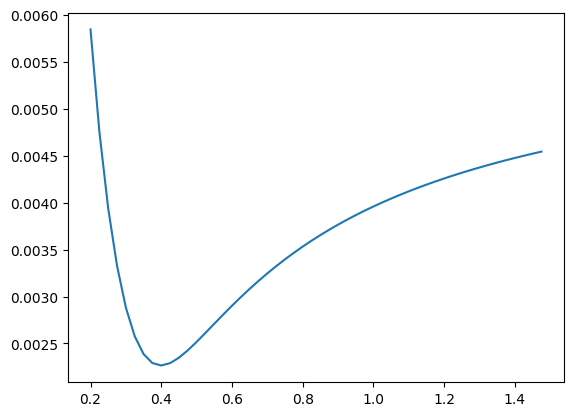

In [9]:
#optimize scaling factor
std_sample = []
for sc in np.arange(0.2,1.5,0.025):
    data_seg = data_net[50,:,:,:].unsqueeze(0)*sc
    data_sample = data_seg.detach().cpu().numpy()-net(data_seg).detach().cpu().numpy()
    data_sample = np.apply_along_axis(lambda x: x/np.mean(x),0,np.squeeze(data_sample))
    std_sample.append(np.std(data_sample))

scale = np.arange(0.2,1.5,0.025)[np.argmin(std_sample)]

print(scale)
plt.plot(np.arange(0.2,1.5,0.025),std_sample)
plt.show()

In [10]:
Denoise_recording(net,data_net,last_data_net,
                  '../../../data/Denoising/280723/data_test_denoised08_depth20_ns03_700_Hbsc_100.mat',
                  10,0.8, noise_scale=scale)

In [22]:
#open the denoised data
data_denoised = loadmat('../../../data/Denoising/data_test_denoised_depth24_800.mat')
data_denoised = torch.tensor(data_denoised['data'], dtype=float, device=dev)

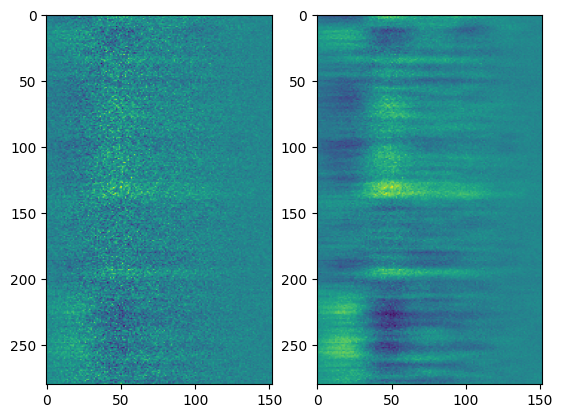

In [23]:
fig, axs = plt.subplots(1,2)
test_seg = np.apply_along_axis(lambda x: x-np.mean(x),0,test_data[2300:2580,:].cpu())
denoised_seg = np.apply_along_axis(lambda x: x-np.mean(x),0,data_denoised[2300:2580,:].cpu())

axs[0].imshow(test_seg,aspect='auto')
axs[1].imshow(denoised_seg,aspect='auto')
plt.show()

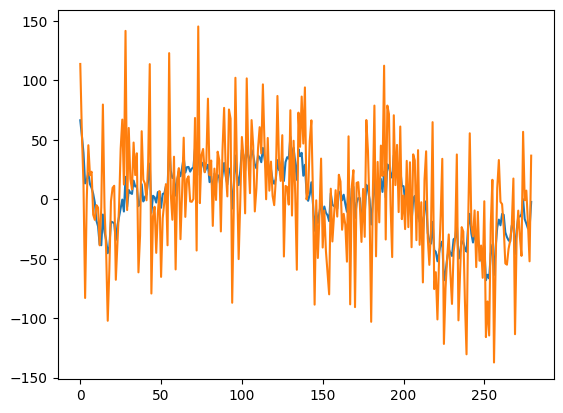

In [13]:
plt.plot(range(280),denoised_seg[:,40]-denoised_seg[:,10])
plt.plot(range(280),test_seg[:,40]-test_seg[:,10])
plt.show()

In [10]:
#load model ensemble
n_models = 20

for i in range(n_models):
    # load model checkpoint
    model_checkpoint = torch.load(f'../model_ensembles/DnCNN_absoluteF_depth20_1300_fastuned_540_{i}.pth',map_location=dev)
    state_dict = model_checkpoint['model_state_dict']
    net = DnCNN(n_channels=1,depth=20,kernel_size=3,padding=1)
    net.load_state_dict(state_dict)
    net.to(dev)
    Denoise_recording(net,data_net,last_data_net,
                  f'../../../data/Denoising/Ensembles/data_test_denoised_1300_fastuned540_{i}.mat',10,0.8)

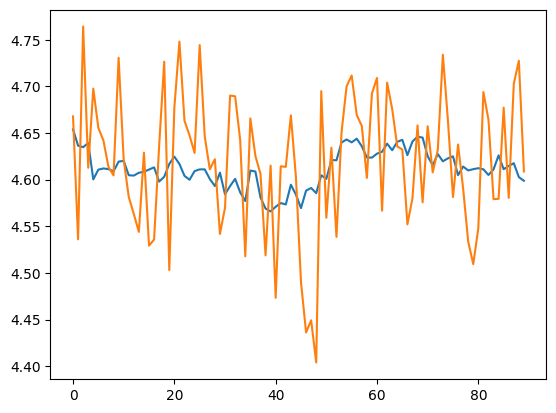

In [ ]:
plt.plot(range(90),np.squeeze(data_sample)[:90,42]/np.squeeze(data_sample)[:90,10])
plt.plot(range(90),np.squeeze(data_seg)[:90,42]/np.squeeze(data_seg)[:90,10])
plt.show()


In [ ]:
data_seg = test_data[500:600,160:312]
data_seg = data_seg-net(data_seg.view((1,1,100,152))).detach().numpy()
data_norm = data_seg-torch.mean(data_seg,dim=0)

plt.imshow(data_norm.T)
plt.show()

RuntimeError: ignored

In [ ]:
data_seg = test_data[500:600,160:332]

plt.imshow(data_norm)
plt.show()